<a href="https://colab.research.google.com/github/andreviniciusmb/ia_ic/blob/main/ProjetoIC_Inadiplencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Inteligência Computacional
O problema escolhido foi referente a previsão de empréstimo com base no comportamento do cliente, então o objetivo aqui será prever quem são os possíveis inadimplentes para um produto de empréstimos ao consumidor, o dataset e a descrição podem ser acessados neste <a href='https://www.kaggle.com/subhamjain/loan-prediction-based-on-customer-behavior'>link</a>.

## Bibliotecas

In [1]:
# Bibliotecas para manipulação de dados e operações matemáticas
import pandas as pd
import numpy as np
from scipy import stats

# Bibliotecas para visualização de dados
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas para categorização e pre-processamento dos dados
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Bibliotecas de pré processamento, validação e avaliação de modelos
from sklearn.metrics import r2_score, mean_squared_error,confusion_matrix,classification_report
from sklearn.feature_selection import RFECV,chi2

# Bibliotecas de Modelos machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Bibliotecas auxiliares
import warnings 

## Seleção e apresentação da base de dados
A base de dados contém 92.704 linhas e 13 colunas.

In [24]:
data = pd.read_csv('Training Data.csv')
print(data.shape)
data.head()

(252000, 13)


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


 ## Limpeza e tratamento dos dados
O dataset tem apenas 1 informação nula e como alternativa para tratá-la, toda a linha daquela informação será removida.

In [25]:
data.isna().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [26]:
data.dropna(axis=0,inplace=True)

In [27]:
data.shape

(252000, 13)

## Análise Exploratória dos Dados

79922 (86.21%) pessoas foram classificadas como sem risco para inadiplência, enquanto 12.781 (13.79%) foram classificadas como risco para inadiplência.

0: 79922 = 86.21%
1: 12781 = 13.79%


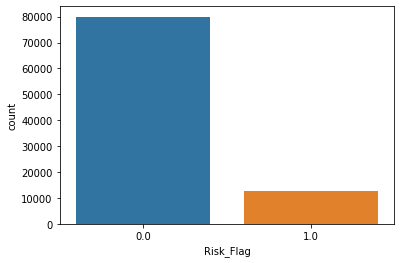

In [ ]:
tam_classe0 = len(data[data['Risk_Flag'] == 0])
tam_classe1 = len(data[data['Risk_Flag'] == 1])
tam_total = len(data)
print('0: {} = {:.2f}%\n1: {} = {:.2f}%'.format(tam_classe0,tam_classe0/tam_total*100,
                                             tam_classe1,tam_classe1/tam_total*100))
sns.countplot(x=data['Risk_Flag'])

Pode-se ver que há uma pequena diferença na renda de quem foi inadiplente e quem não foi.

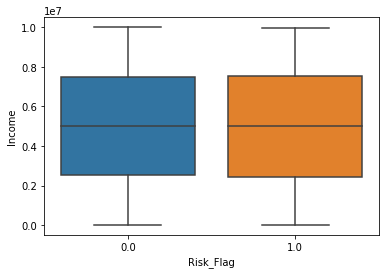

In [ ]:
sns.barplot(y=data['Income'],x=data['Risk_Flag'])
plt.ylim(4.4e6,5.4e6)

Não há uma diferença expressiva entre a idade das classes de risco de inadiplência.

In [ ]:
data[data['Risk_Flag'] == 0]['Age'].describe()

count    79922.000000
mean        50.150835
std         17.008736
min         21.000000
25%         35.000000
50%         50.000000
75%         65.000000
max         79.000000
Name: Age, dtype: float64

In [ ]:
data[data['Risk_Flag'] == 1]['Age'].describe()

count    12781.000000
mean        49.015961
std         17.304496
min         21.000000
25%         33.000000
50%         49.000000
75%         64.000000
max         79.000000
Name: Age, dtype: float64

Os casos de inadiplência ocorrem em maior número envolvendo pessoas solteiras.

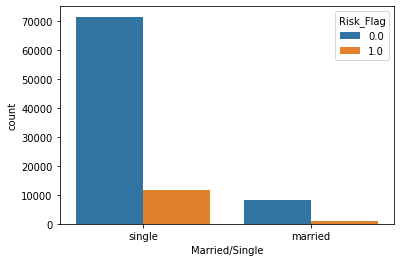

In [ ]:
sns.countplot(x=data['Married/Single'], hue=data['Risk_Flag'])

Tem-se um maior número de inadiplentes com pessoas que não possuem um veículo próprio.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


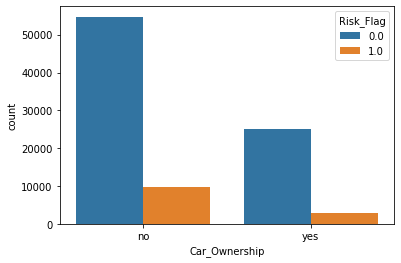

In [ ]:
sns.countplot(data['Car_Ownership'], hue=data['Risk_Flag'])

Pode-se analisar que a maioria dos inadiplentes sde encontram entre 20 e 30 anos, não tendo a experiencia como fator decisivo.

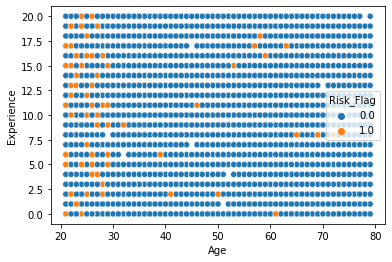

In [ ]:
sns.scatterplot(x='Age',y='Experience',data=data,hue='Risk_Flag')

Não há uma diferença significativa, mas pode-se perceber um aumento no número de inadiplentes em pessoas até 30 anos.

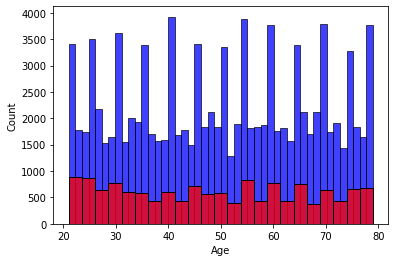

In [ ]:
sns.histplot(x=data.loc[data['Risk_Flag'] == 0]['Age'],color='b')
sns.histplot(x=data.loc[data['Risk_Flag'] == 1]['Age'],color='r')

## Correlação

In [ ]:
data.dtypes

Id                     int64
Income                 int64
Age                    int64
Experience           float64
Married/Single        object
House_Ownership       object
Car_Ownership         object
Profession            object
CITY                  object
STATE                 object
CURRENT_JOB_YRS      float64
CURRENT_HOUSE_YRS    float64
Risk_Flag            float64
dtype: object

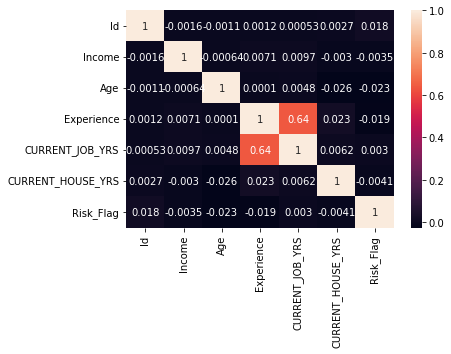

In [ ]:
sns.heatmap(data.corr(), annot=True);

## Etapa 2 
Esta etapa consiste em aprofundar as análises, realizar a seleção das variáveis, criar o modelo de classificação, e por uúltimo usar pelo menos 2 métodos para comparar e avaliar o desempenho dos modelos.

### Categorizando algumas variáveis...

In [28]:
data['Married/Single'].value_counts()

single     226272
married     25728
Name: Married/Single, dtype: int64

In [29]:
data['House_Ownership'].value_counts()

rented          231898
owned            12918
norent_noown      7184
Name: House_Ownership, dtype: int64

In [30]:
data['Car_Ownership'].value_counts()

no     176000
yes     76000
Name: Car_Ownership, dtype: int64

Married/Single: 0 se a pessoa for solteira, 1 se for casada.

In [31]:
data['Married/Single'] = data['Married/Single'].apply(lambda x: 0 if x == 'single' else 1)

Codificando a variável House_Ownership usando o Label Encoder, esse método "mapeia" cada rótulo a um número inteiro.

In [32]:
codificador = LabelEncoder()
codificador.fit(data['House_Ownership'])
data['House_Ownership'] = codificador.transform(data['House_Ownership'])

Para a variável Car_Ownership, 1 indicará que a pessoa possui carro e 0 que não possuir carro.

In [33]:
data['Car_Ownership'] = data['Car_Ownership'].apply(lambda x: 0 if x == 'no' else 1)

### Matriz de Correlação
Como estamos olhando para dados em sua maioria discretos, usaremos o método de sperman, que é mais indicado para variáveis discretos. Mas podemos ver abaixo que nenhuma variável possui uma forte correlação inicialmente com a variável target, Risk_Flag.

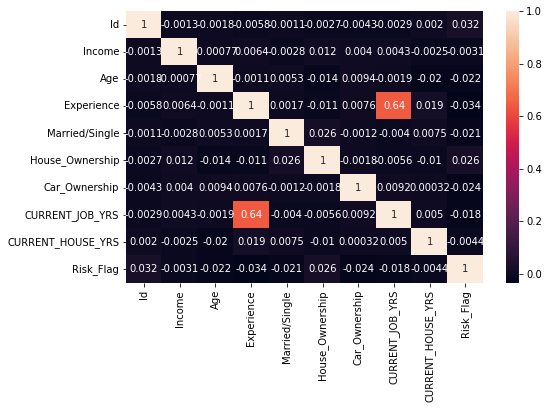

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(data.corr(method='spearman'),  annot=True);

## Seleção de Variáveis
Para seleção das variáveis usarei alguns métodos descritos na documentação do scikit-learn e também alguns que aprendi durante a faculdade. \
Referência: https://scikit-learn.org/stable/modules/feature_selection.html#:~:text=Feature%20selection%C2%B6%20The%20classes%20in%20the%20sklearn.feature_selection%20module,high-dimensional%20datasets.%201.13.1.%20Removing%20features%20with%20low%20variance%C2%B6

In [34]:
X = data.drop(['Id','Risk_Flag','Profession', 'CITY', 'STATE'],axis=1)
y = data['Risk_Flag']

Selecionando as variáveis mais importantes pela Random Forest temos: 
- Income
- Age
- Experience
- CURRENT_JOB_YRS
- CURRENT_HOUSE_YRS

In [ ]:
modelo = RandomForestClassifier()
modelo.fit(X, y)

i = 0
aux = pd.DataFrame()
for coluna,importancia in zip(X.columns,modelo.feature_importances_):
  aux.loc[i,'Coluna'] = coluna
  aux.loc[i,'Importancia'] = importancia
  i += 1

aux.sort_values('Importancia')

,Coluna,Importancia
3,Married/Single,0.008774
4,House_Ownership,0.009545
5,Car_Ownership,0.013119
7,CURRENT_HOUSE_YRS,0.079545
6,CURRENT_JOB_YRS,0.101378
2,Experience,0.112882
1,Age,0.267860
0,Income,0.406896


Ao ordenarmos pelo p-valor temos:
- Income
- Experience
- Age
- CURRENT_JOB_YRS
- Car_Ownership

In [ ]:
f_score = chi2(X,y)
p_valores = pd.Series(f_score[0])
p_valores.index = X.columns
p_valores.sort_values(ascending=False)

Income               3.992087e+06
Experience           1.073079e+03
Age                  6.986581e+02
CURRENT_JOB_YRS      1.518872e+02
Car_Ownership        1.016771e+02
Married/Single       1.006588e+02
House_Ownership      1.141555e+01
CURRENT_HOUSE_YRS    7.869449e-01
dtype: float64

## Modelagem
Conforme vimos durante a seleção de variáveis as variáveis mais importantes foram: . E a partir dessa informações, construiremos 4 modelos, 2 para Random Forest e 2 para a Regressão Logística, um contendo todas as variáveis e outro contendo as variáveis selecionadas pelos métodos acima.

### Regressão Logística

In [ ]:
## Usando todas as colunas
X_train,X_test,y_train,y_test = train_test_split(data.drop(['Risk_Flag','Profession', 'CITY', 'STATE'],axis=1),
                                                 data['Risk_Flag'],test_size=0.3)

modelo1 = LogisticRegression()
modelo1.fit(X_train,y_train)
predicao1 = modelo1.predict(X_test)

print(confusion_matrix(y_test,predicao1))
print(classification_report(y_test,predicao1))

[[66387     0]
 [ 9213     0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     66387
           1       0.00      0.00      0.00      9213

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## Usando somente as colunas selecionadas
colunas_modelo = ['Income','Experience','Age','CURRENT_JOB_YRS']
X_train,X_test,y_train,y_test = train_test_split(data[colunas_modelo], data['Risk_Flag'], test_size=0.3)

modelo2 = LogisticRegression()
modelo2.fit(X_train,y_train)
predicao2 = modelo2.predict(X_test)

print(confusion_matrix(y_test,predicao2))
print(classification_report(y_test,predicao2))

[[66287     0]
 [ 9313     0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66287
           1       0.00      0.00      0.00      9313

    accuracy                           0.88     75600
   macro avg       0.44      0.50      0.47     75600
weighted avg       0.77      0.88      0.82     75600



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [ ]:
## Usando todas as colunas
colunas = ['Income', 'Age', 'Experience', 'Married/Single', 'House_Ownership',
           'Car_Ownership','CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']
           
X_train,X_test,y_train,y_test = train_test_split(data[colunas],
                                                 data['Risk_Flag'],test_size=0.3)

modelo3 = RandomForestClassifier()
modelo3.fit(X_train,y_train)
predicao3 = modelo3.predict(X_test)

print(confusion_matrix(y_test,predicao3))
print(classification_report(y_test,predicao3))

[[62924  3440]
 [ 4223  5013]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     66364
           1       0.59      0.54      0.57      9236

    accuracy                           0.90     75600
   macro avg       0.77      0.75      0.75     75600
weighted avg       0.90      0.90      0.90     75600



In [15]:
## Usando somente as colunas selecionadas
colunas_modelo = ['Income','Experience','Age','CURRENT_JOB_YRS']
X_train,X_test,y_train,y_test = train_test_split(data[colunas_modelo], data['Risk_Flag'], test_size=0.3)

modelo4 = RandomForestClassifier()
modelo4.fit(X_train,y_train)
predicao4 = modelo4.predict(X_test)

print(confusion_matrix(y_test,predicao4))
print(classification_report(y_test,predicao4))

[[62546  3857]
 [ 4102  5095]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     66403
           1       0.57      0.55      0.56      9197

    accuracy                           0.89     75600
   macro avg       0.75      0.75      0.75     75600
weighted avg       0.89      0.89      0.89     75600



## Etapa 3

### Seleção de Variáveis

In [35]:
colunas_ordenadas = ['Income','Age','Experience','CURRENT_JOB_YRS','CURRENT_HOUSE_YRS','Car_Ownership','House_Ownership','Married/Single']

In [36]:
colunas = ['Risk_Flag']

score_max = -1
for i in colunas_ordenadas:
  baseline = pd.DataFrame()
  colunas.append(i)
  baseline = data[colunas]
  print('Colunas: ' , baseline.columns)
  modelo = RandomForestClassifier()
  modelo.fit(baseline.drop('Risk_Flag',axis=1),baseline['Risk_Flag'])
  score = modelo.score(baseline.drop('Risk_Flag',axis=1),baseline['Risk_Flag'])
  if score_max < score:
    print('Adicionou ' , str(i))
    score_max = score
  else:
    baseline.drop(i,axis=1)
    colunas.remove(i)

print('Score maximo: ' , score_max)
print('Colunas usadas: ' , baseline.columns)

Colunas:  Index(['Risk_Flag', 'Income'], dtype='object')
Adicionou  Income
Colunas:  Index(['Risk_Flag', 'Income', 'Age'], dtype='object')
Adicionou  Age
Colunas:  Index(['Risk_Flag', 'Income', 'Age', 'Experience'], dtype='object')
Adicionou  Experience
Colunas:  Index(['Risk_Flag', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS'], dtype='object')
Colunas:  Index(['Risk_Flag', 'Income', 'Age', 'Experience', 'CURRENT_HOUSE_YRS'], dtype='object')
Adicionou  CURRENT_HOUSE_YRS
Colunas:  Index(['Risk_Flag', 'Income', 'Age', 'Experience', 'CURRENT_HOUSE_YRS',
       'Car_Ownership'],
      dtype='object')
Adicionou  Car_Ownership
Colunas:  Index(['Risk_Flag', 'Income', 'Age', 'Experience', 'CURRENT_HOUSE_YRS',
       'Car_Ownership', 'House_Ownership'],
      dtype='object')
Colunas:  Index(['Risk_Flag', 'Income', 'Age', 'Experience', 'CURRENT_HOUSE_YRS',
       'Car_Ownership', 'Married/Single'],
      dtype='object')
Score maximo:  0.9355079365079365
Colunas usadas:  Index(['Risk_Flag', '

In [38]:
## Usando colunas do BORUTA
colunas = ['Income', 'Age', 'Experience', 'CURRENT_HOUSE_YRS',
       'Car_Ownership', 'Married/Single']
           
X_train,X_test,y_train,y_test = train_test_split(data[colunas],
                                                 data['Risk_Flag'],test_size=0.3)

modelo5 = RandomForestClassifier()
modelo5.fit(X_train,y_train)
predicao5 = modelo5.predict(X_test)

print(confusion_matrix(y_test,predicao5))
print(classification_report(y_test,predicao5))

[[62679  3587]
 [ 4267  5067]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     66266
           1       0.59      0.54      0.56      9334

    accuracy                           0.90     75600
   macro avg       0.76      0.74      0.75     75600
weighted avg       0.89      0.90      0.89     75600



### Utilizando dados balanceados

In [40]:
qtd_0 = len(data[data['Risk_Flag']==0])
qtd_1 = len(data[data['Risk_Flag']==1])
print(qtd_0,qtd_1)

data_balanceado = pd.concat([data[data['Risk_Flag']==0].sample(n=qtd_1) , data[data['Risk_Flag']==1]]) 
print(len(data_balanceado)) 

221004 30996
61992


In [42]:
## Usando colunas do BORUTA
colunas = ['Income','Experience','Age','CURRENT_JOB_YRS']
           
X_train,X_test,y_train,y_test = train_test_split(data_balanceado[colunas],
                                                 data_balanceado['Risk_Flag'],test_size=0.3)

modelo6 = RandomForestClassifier()
modelo6.fit(X_train,y_train)
predicao6 = modelo6.predict(X_test)

print(confusion_matrix(y_test,predicao6))
print(classification_report(y_test,predicao6))

[[8102 1293]
 [1395 7808]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      9395
           1       0.86      0.85      0.85      9203

    accuracy                           0.86     18598
   macro avg       0.86      0.86      0.86     18598
weighted avg       0.86      0.86      0.86     18598



# Conclusão
Nesse projeto percebeu-se que ao utilizar apenas 4 colunas ('Income','Experience','Age','CURRENT_JOB_YRS') consegui-se atingir os resultados da modelagem com todas as colunas do dataset, outro ponto encontrado foi que o balanceamento do dataset embora diminua a acurácia do modelo, possibilitou um maior equilíbrio e acerto na inadiplência de um cliente, tendo portanto um maior significado para o negócio em si pois é melhor e menos custoso para o banco errar que uma pessoa vai pagar, do que errar que ela não vai pagar, tornando consequentemente um inadiplente.